# 开始之前
在训练时，我们通常不会一次性把整个数据集送进模型，而是分成小批量（mini-batch）。
如果你设置 batch_size=256，那么每次前向传播时，模型会接收 256 张图片。

输入张量的形状就是：(256,784)
输出张量的形状就是：(256,10)

其中 784 是每张图片展平后的像素数。

In [20]:
import torch
from IPython import display
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

# 初始化模型参数
仔细思考一下模型参数的维度怎么来的，类比之前线性回归进行思考。

输出是10个类别，所以最后y是1 x 10的矩阵。
输入是28 x 28像素的图像，经过展平处理后就是784个元素，也就是1 x 784。
公式是y = xW + b。
所以W的矩阵结构就是784 x 10，b偏置量的矩阵结构就是1 x 10。

这里权重初始同样用标准正态分布来表示。

In [21]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

# 定义softmax操作

dim=0 表示 沿着行方向求和（也就是“纵向”把每一列加起来）
dim=1 表示 沿着列方向求和（也就是“横向”把每一行加起来）
keepdim=True，会保留原来的维度

In [22]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

实现softmax回归的步骤：
1. 对每个项求幂（使用exp）；
2. 对每一行求和（小批量中每个样本是一行），得到每个样本的规范化常数；
3. 将每一行除以其规范化常数，确保结果的和为1。

联系“开始之前”的内容，再去理解下面的矩阵计算步骤。

最后输出张量的形状是（256, 10），每一行都是输入的图片，每一列都是对应着分类的类别，所以下面要计算列方向的和。

In [23]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition

模拟生成样本来验证softmax函数以及归一性的正确性。

In [24]:
X = torch.normal(0, 1, (2, 5 ))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.0446, 0.1320, 0.6583, 0.0618, 0.1033],
         [0.2723, 0.0899, 0.2436, 0.3513, 0.0430]]),
 tensor([1.0000, 1.0000]))

# 定义模型
softmax回归模型的前向传播。

In [25]:
W.shape[0]

784

这里前向传播的思路就是对y = xW + b的结果进行softmax。相当于是softmax（y）

- X.reshape（（-1, W.shape[0]））
1. 这么写的作用是把输入X重塑成二维矩阵，其中行数自动求出（-1的性质），列数为权重W的行数。
   为什么多此一举？
   保证即使输入是单张图片，也能够经过reshape成（1,784）
2. 为什么这里要用两个括号？
   是一个代码写作习惯，内部括号是元组结构，能够一眼看出里面是张量的维度。
   值得学习的代码习惯

In [26]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

# 定义损失函数
实现交叉熵损失函数。

- 为什么不用MSE？MSE是之前学过的损失函数不是吗？
  
并不是说不能用MSE。
首先要改变一个观念，并不是说对输入的类别经过独热编码以后，就可以把预测值和输入值直接做差了。
首先softmax输出的是一个概率，并不是只有0,1。所以直接做差的直接思路本身就是错的

再者使用交叉熵损失函数后，可以让预测越准，损失越小；预测越差，损失越大。
而使用MSE的话，模型会“耗费更多训练步骤”才能学到同样的东西。

In [27]:

y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
# 高级索引的用法，取出y_hat中[0, 0]以及[1, 2]位置的元素
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

交叉熵损失函数的实现

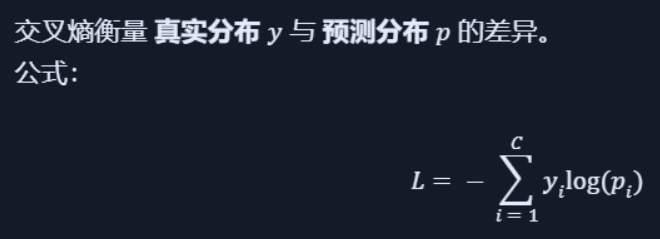

损失函数效果大致如下图所示（自己手绘）
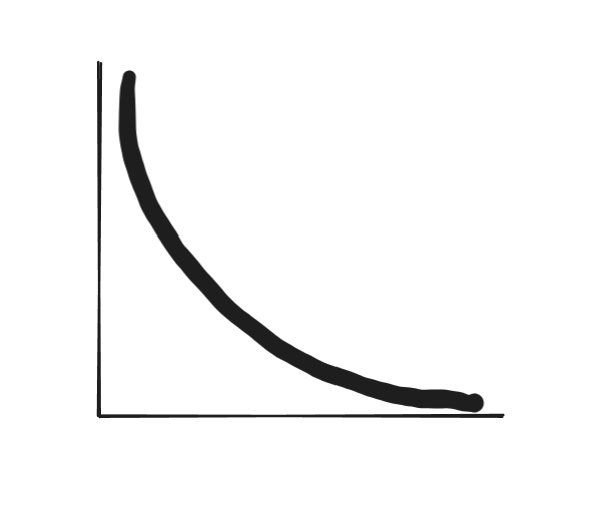

In [28]:
# 在 PyTorch 里，len(tensor) 返回的是 张量第 0 维的大小，也就是行数
len(y_hat)

2

In [29]:
# y_hat就是模型预测的概率分布，也就是上面的p。
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

上面书中给出的代码仔细观察会发现和交叉熵损失函数的公式有一些细微的差别。前面少乘了真实值标签。

这是怎么回事？

先用传统方法实现后再去理解上面的代码实现方式

one-hot编码实现方式的代码思路。



In [30]:
len(y)

2

In [31]:
# 直接在notebook中写range(2)不会输出[0, 1]，需要用List进行转换
list(range(2))

[0, 1]

In [32]:
# 转换成one-hot标签
# 首先构建一个和预测值相同的0矩阵（2 x 3）
y_onehot = torch.zeros_like(y_hat)
# 利用高级索引，把真实标签转换为one-hot编码类型的矩阵
# len(y)=2, range(2)会输出[0, 1]，y是[0, 2]
# 经过配对以后，会把[0, 0]以及[1, 2]位置的元素赋值为1
# 最终结果就是真实标签 0：[1, 0, 0]，2：[0, 0 ,1]
y_onehot[range(len(y)), y] = 1
print("One-hot 标签:\n", y_onehot)

# 按公式计算交叉熵
loss_onehot = -(y_onehot * torch.log(y_hat)).sum(dim=1)
print("公式版交叉熵:\n", loss_onehot)

One-hot 标签:
 tensor([[1., 0., 0.],
        [0., 0., 1.]])
公式版交叉熵:
 tensor([2.3026, 0.6931])


此时再去理解一下，为什么前面书中给出的交叉熵损失函数并没有乘以经过独热编码后的真实标签？

因为经过独热编码后的向量值的作用本身就是挑出真实类别对应的预测概率，而书中的写法更聪明！  
y_hat[range(len(y_hat)), y]  
这里利用高级索引，挑选出真实类别对应的概率。  
len(y_hat) = 2  
range(len(y_hat)) = [0, 1]  
y = [0, 2]  
最后经过匹配，会筛选出[0, 0]以及[1, 2]位置的元素，是不是和之前用one-hot编码的效果一样！

# 分类精度

In [40]:
def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    # 检查y_hat是否是二维的，并且列数是否大于1
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
    # 使用argmax(axis=1) 找出每个样本预测分数最大的类别索引。沿着列方向寻找，也就是找到每一行的预测分数最大的索引
    # y_hat = [[0.1, 0.3, 0.6],[0.3, 0.2, 0.5]]，y_hat.argmax(axis=1) = [2, 2]
    # 表示两个样本都预测为类别 2。（概率预测最大值的索引值和预测类别是一样的）
        y_hat = y_hat.argmax(axis=1)
    # 将 y_hat 转换为和 y 相同的数据类型（通常是 torch.int64）。
    # 逐元素比较预测类别和真实类别，得到一个布尔向量。
    # y_hat = [2, 2]
    # y = [0, 2]
    # cmp = [False, True]
    cmp = y_hat.type(y.dtype) == y
    # 把布尔值转成整数（True→1，False→0），求和，得到预测正确的样本数
    return float(cmp.type(y.dtype).sum())

In [34]:
accuracy(y_hat, y) / len(y)

0.5

In [35]:
def evaluate_accuracy(net, data_iter):
    """计算在制定数据集上模型的精度"""
    # 检查 net 是否是 PyTorch 的神经网络模型。
    if isinstance(net, torch.nn.Module):
    # 设置进入评估模式（简单理解，评估模式主要用于验证集评估模型性能以及测试集进行模型测试）
        net.eval() 
    metric = Accumulator(2) # 正确预测数、预测总数
    # 告诉pytorch在接下来的步骤中不需要计算梯度，因为在模型评估阶段，不再需要对参数进行更新
    with torch.no_grad():
        # 遍历iter中的所有数据批次
        # metric[0]中保存的是预测中的正确样本数量，metric[1]中保存的是y样本总数
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    # 累计正确预测数 / 累计总体样本数 = 整体准确率
    return metric[0] / metric[1]

In [36]:
# 有关class的内容详见菜鸟教程
# 更详细的步骤见下方的cell
class Accumulator:
    """在n个变量上累加"""
    def __init__(self, n):
        # 这行代码的作用是：根据传入的 n，为这个新的 Accumulator 对象初始化一个用于存储累加值的列表，并把所有初始值设为 0。
        # self.data 的意思是：“请在 我 (self) 这个实例上，创建一个名为 data 的属性（变量）”。这个属性是属于这个实例的
        # [0.0] * n 是一个 Python 列表的技巧。它会创建一个包含 n 个 0.0 的列表。例如，如果 n 是 2，self.data 就会变成 [0.0, 0.0]
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [37]:
# 1. 创建一个 Accumulator 的实例（对象），我们给它取名叫 metric
#    我们需要累加两个值：“正确预测数”和“总预测数”，所以 n=2
metric = Accumulator(2) 

#    此时，Python 在背后做了什么？
#    a. 创建了一个 Accumulator 对象
#    b. 自动调用了 __init__ 方法：metric.__init__(2)
#    c. 在 __init__ 方法内部，执行了 self.data = [0.0] * 2
#    d. 所以现在 metric 对象有一个属性 data，它的值是 [0.0, 0.0]
print(f"初始化后: metric.data = {metric.data}")

# 2. 模拟第一次循环，假设我们处理了一个批次的数据
#    这个批次大小是 32，其中有 30 个预测正确了
#    我们调用 add 方法来更新累加器
metric.add(30, 32) # 第一个参数对应正确数，第二个对应总数

#    此时，Python 在背后做了什么？
#    a. 调用了 add 方法：metric.add(30, 32)
#    b. self 就是 metric 对象，*args 是 (30, 32)
#    c. zip(metric.data, args) 也就是 zip([0.0, 0.0], (30, 32)) -> [(0.0, 30), (0.0, 32)]
#    d. 列表推导式计算出 [0.0 + 30, 0.0 + 32] -> [30.0, 32.0]
#    e. metric.data 被更新为 [30.0, 32.0]
print(f"第一批后: metric.data = {metric.data}")

# 3. 模拟第二次循环，又处理了一个批次的数据
#    这个批次大小也是 32，其中有 28 个预测正确了
metric.add(28, 32)

#    此时，Python 在背后做了什么？
#    a. 调用 add 方法
#    b. zip(metric.data, args) 也就是 zip([30.0, 32.0], (28, 32)) -> [(30.0, 28), (32.0, 32)]
#    c. 列表推导式计算出 [30.0 + 28, 32.0 + 32] -> [58.0, 64.0]
#    d. metric.data 被更新为 [58.0, 64.0]
print(f"第二批后: metric.data = {metric.data}")

# 4. 整个数据集都遍历完了，我们需要计算最终的准确率
#    我们需要取出总的正确数和总的样本数
total_correct = metric[0] # 这里就用到了 __getitem__ 方法
total_samples = metric[1] # Python 看到 metric[0]，就会去调用 metric.__getitem__(0)

#    __getitem__(0) 返回 metric.data[0]，也就是 58.0
#    __getitem__(1) 返回 metric.data[1]，也就是 64.0
print(f"总正确数: {total_correct}")
print(f"总样本数: {total_samples}")

# 5. 计算准确率
accuracy = total_correct / total_samples
print(f"最终准确率: {accuracy}")

# 6. 如果我们想用这个累加器做一次新的计算，可以重置它
metric.reset()
print(f"重置后: metric.data = {metric.data}")

初始化后: metric.data = [0.0, 0.0]
第一批后: metric.data = [30.0, 32.0]
第二批后: metric.data = [58.0, 64.0]
总正确数: 58.0
总样本数: 64.0
最终准确率: 0.90625
重置后: metric.data = [0.0, 0.0]


In [41]:
evaluate_accuracy(net, test_iter)

0.1063

# 训练

In [49]:
# 模型一个完整迭代周期的训练
# net：要训练的神经网络模型
# train_iter：训练数据集的迭代器
# loss：损失函数
# updater：优化器
def train_epoch_ch3(net, train_iter, loss, updater):
    """训练模型一个迭代周期"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        # 根据优化器是内置还是自定义来执行不同操作
        if isinstance(updater, torch.optim.Optimizer):
            # 使用Pytorch内置的优化器和损失函数
            # 清零上一次迭代计算得到的梯度，防止梯度累计
            updater.zero_grad()
            # 反向传播。由于 PyTorch 内置的损失函数通常返回一个批次上的平均损失，所以直接调用 .backward() 计算所有可训练参数的梯度。
            l.mean().backward()
            #  更新参数。优化器根据计算出的梯度来调整模型的参数（如权重和偏差）
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            # 调用自定义的优化器（它可能是一个函数或一个自定义类实例），并将当前批次的样本数（X.shape[0]，即 batch size）作为参数传入，用于自定义的参数更新逻辑。
            updater(X.shape[0])
        # l.sum(): 获取当前批次的损失总和（float() 用于将其转换为普通数值）
        # accuracy(y_hat, y): 某个自定义的准确度计算函数，计算当前批次中预测正确的样本数
        # y.numel(): 获取当前批次的样本总数（即 batch size）
        # metric.add(...): 将这三个数值累加到 Accumulator 中
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    # metric[0] / metric[2]: 返回平均训练损失 = （总损失）/（总样本数）
    # metric[1] / metric[2]: 返回平均训练精度 = （总正确预测数）/（总样本数）
    return metric[0] / metric[2], metric[1] / metric[2]
        

In [43]:
# 辅助工具，并非核心算法
# 专门写的一个绘制数据的封装库，就不具体了解其中的实现了，先更关注神经网络的架构
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [51]:
# 定义训练模型函数，传入参数含义如下
# net：要训练的神经网络模型
# train_iter：训练数据集的迭代器
# test_iter：测试数据集的迭代器
# loss：损失函数
# num_epochs：训练周期数
# updater：优化器或参数更新函数
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    """训练模型"""
    # 设置用于绘制训练损失、训练精度和测试精度三条曲线的绘图工具
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    # 标准的主训练循环，从 0 遍历到 num_epochs - 1。总计num_epochs次。
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    # 断言检查部分，用于确保模型在训练结束时达到了预期的性能门槛（在本例中，要求训练损失小于 0.5，且训练精度和测试精度都大于 0.7）
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <=1 and test_acc > 0.7, test_acc

In [45]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

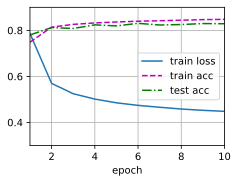

In [46]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

# 预测

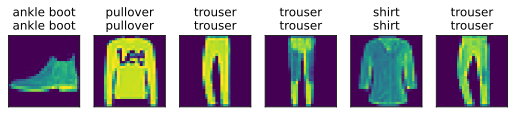

In [50]:
# 传入参数
# 已经训练好的神经网络模型
# 测试数据集的迭代器
# 展示的样本数量
def predict_ch3(net, test_iter, n=6):
    """预测标签"""
    # 仅取出第一个批次就退出
    for X, y in test_iter:
        break
    # 将数字形式的标签 y（如 0, 1, ..., 9）转换为 Fashion-MNIST 对应的文本描述（如 "T-shirt", "Trouser" 等）
    trues = d2l.get_fashion_mnist_labels(y)
    # 沿着类别维度（axis=1）取最大值对应的索引，即模型预测的类别
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    # 使用列表推导式和 zip 函数，将真实标签和预测标签一一配对，并用换行符 \n 连接起来，形成最终的标题列表 titles
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)
    